In [232]:
import argparse
import os
from kabuki.analyze import gelman_rubin
import pandas
import hddm
import numpy as np

path = '/home/gdholla1/projects/bias/data/hddm_fits'

def get_model(model):
    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior.pandas')

    # Prepare data
    data = df[['cue_validity', 'rt', 'correct', 'difficulty', 'subj_idx']]
    data['response'] = data['correct']
    data['rt'] = data['rt'] / 1000.
    data = data[(data.rt > .2) & (data.rt < 1.5)]
    data = data[~data.rt.isnull()]
    data['cue_coding'] = data.cue_validity.map({'valid':1, 'neutral':0, 'invalid':-1})

    def z_link_func(x, data=data):
        return 1 / (1 + np.exp(-(x.values.ravel())))

    regs, free_pars = model.split('_')

    if regs == 'drift':
        z_reg = {'model': 'z ~ 0', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}
    elif regs == 'startpoint':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)', 'link_func': lambda x: x}
    elif regs == 'both':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}

    reg_descr = [z_reg, v_reg]

    if free_pars == 'sv':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])
    elif free_pars == 'sz':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sz'), bias=True, group_only_regressors=False, group_only_nodes=['sz'])
    elif free_pars == 'svsz':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz'])
    elif free_pars == 'all':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])
    
    
    # NOW FIND, LOAD, AND CONCAT TRACES
    reg = re.compile('.*/traces_{model}_[0-9]+.pkl'.format(**locals()))
    fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_*.pkl'.format(**locals())) if reg.match(fn)]

    hddm_model.load_db(fns[0], db='pickle')

    for fn in fns[1:]:
        traces = pkl.load(open(fn))    
        for node in hddm_model.get_stochastics().node:
            node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])        


    return hddm_model

In [233]:
import glob
import re

import pickle as pkl

In [234]:
model = get_model('both_all')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [235]:
traces = model.get_traces()
traces.shape

(9000, 129)

In [228]:
r = []

for i in np.arange(1, 20):
    r.append({'subj_idx':i,
              'z_cue_coding':traces['z_cue_coding_subj.%d' % i].mean(),
              'v_cue_coding':traces['v_cue_coding_subj.%d' % i].mean(),
              'v_difficulty':traces['v_C(difficulty)[T.hard]_subj.%d' % i].mean()})
    
df = pandas.DataFrame(r)

In [231]:
df.to_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')

# Posterior predictive checks

In [ ]:
ppc_data = hddm.utils.post_pred_gen(model, samples=100)

 [-----------------52%                  ] 10 of 19 complete in 2009.1 sec

In [335]:
# Make a column that make clear which nth sample from the posterior was used
ppc_data['sample'] = ppc_data.index.get_level_values(1)


# Merge with real data, so we know the corresponding trial conditions
ppc_data_merged = model.data[['cue_validity', 'difficulty', 'subj_idx']].merge(ppc_data.set_index(ppc_data.index.get_level_values(2)), left_index=True, right_index=True)

In [336]:
def get_quantile_dataframe(d, q=(0.1, 0.3, 0.5, 0.7, 0.9)):
    q_ub, q_lb, prop_ub = hddm.utils.data_quantiles(d)
    
    df_ub = pandas.DataFrame({'q_rt':q_ub, 'prop':np.array(q)*prop_ub, 'q':q})
    df_ub['bound'] = 'ub'
    
    df_lb = pandas.DataFrame({'q_rt':q_lb, 'prop':np.array(q)*(1-prop_ub), 'q':q})    
    df_lb['bound'] = 'lb'
    
    return pandas.concat((df_ub, df_lb))


In [339]:
sns.set_context('paper')

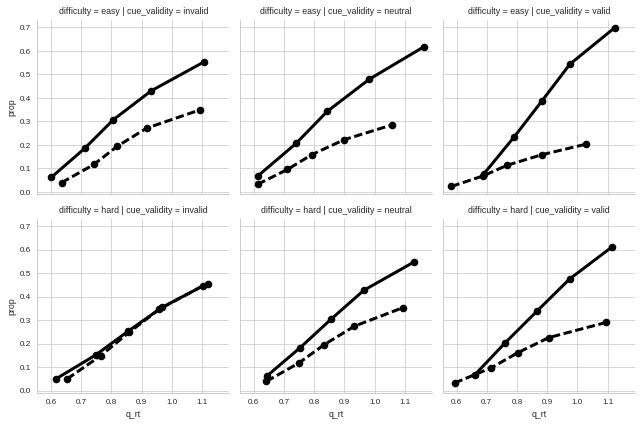

In [380]:
# Make quantiles per subject
data_quantiles = model.data.groupby(['subj_idx', 'cue_validity', 'difficulty']).apply(get_quantile_dataframe)

# Mean quantiles over subjects
data_quantiles = data_quantiles.reset_index().groupby(['cue_validity', 'difficulty', 'q', 'bound'], as_index=False).mean()

# Make a FacetGrid to plot the quantiles over conditions
fac = sns.FacetGrid(data_quantiles, col='cue_validity', row='difficulty', hue='bound', hue_kws={'ls':['--', '-']})
fac.map(plt.plot, 'q_rt', 'prop', lw=3, color='k', marker='o', markeredgewidth=2)

In [356]:
model_quantiles = ppc_data_merged.groupby(['sample', 'subj_idx', 'cue_validity', 'difficulty']).apply(get_quantile_dataframe)

In [357]:
model_quantiles = model_quantiles.reset_index().groupby(['sample', 'cue_validity', 'difficulty', 'q', 'bound'], as_index=False).mean()

In [ ]:
def hexbin(x, y, color, **kwargs):
    plt.hexbin(x, y, **kwargs)

fac_model = sns.FacetGrid(model_quantiles, col='cue_validity', row='difficulty')
fac_model.map(hexbin, 'q_rt', 'prop', gridsize=25, cmap=plt.cm.viridis, extent=[.5, 1.25, 0, 1])

fac = sns.FacetGrid(data_quantiles, col='cue_validity', row='difficulty', hue='bound', hue_kws={'ls':['--', '-']})
fac.fig = fac_model.fig
fac.axes = fac_model.axes
fac.map(plt.plot, 'q_rt', 'prop', lw=3, color='w', marker='o', markeredgewidth=2, alpha=.7)
fac.fig.savefig('/home/gdholla1/projects/bias/reports/hddm_fit_both.pdf')

# fac.fig.set_size_inches(30, 25)